In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf


2024-08-16 19:22:45.828902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 19:23:31.325597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 19:23:44.337454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 19:25:15.849693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 19:27:23.819255: W tensorflow/compiler/tf2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# ---------------------- Filter to our wanted classes only ---------------------
# Define the classes you want to keep (e.g., class 0 and class 1)
# classes = ('car', 'frog', 'horse', 'ship')
classes_to_keep = [1, 6, 7, 8]

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Function to filter the dataset by the specified classes
def filter_dataset_by_class(dataset, classes):
    # Get the data and targets
    data, targets = dataset.data, torch.tensor(dataset.targets)

    # Create a mask for the classes you want to keep
    mask = torch.isin(targets, torch.tensor(classes))

    # Filter the data and targets
    filtered_data = data[mask.numpy()]
    filtered_targets = targets[mask].numpy()

    for i in range(len(filtered_targets)):
      filtered_targets[i] = classes.index(filtered_targets[i])

    # Update the dataset's data and targets
    dataset.data = filtered_data
    dataset.targets = filtered_targets

# Size of the unfiltered sets
print(f'Unfiltered train set size: {len(trainset)}')
print(f'Unfiltered test set size: {len(testset)}')
print(f'Unfiltered classes: {trainset.classes}')

# Filter the train and test sets
filter_dataset_by_class(trainset, classes_to_keep)
filter_dataset_by_class(testset, classes_to_keep)

# Now the trainset and testset objects are still CIFAR10 datasets, but only contain the selected classes
print(f'Filtered train set size: {len(trainset)}')
print(f'Filtered test set size: {len(testset)}')
print(f'Filtered classes: {trainset.classes}')

# Create DataLoader for the filtered datasets
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Example: Iterate through the filtered trainloader
for i, (images, labels) in enumerate(trainloader):
    print(f'Batch size: {images.size(0)}, Labels: {labels}')
    if i == 3:
      break

print(trainset)
print(testset)

  4%|▍         | 7503872/170498071 [12:20<4:27:54, 10139.65it/s]

KeyboardInterrupt



In [2]:
from torch.utils.data import Dataset, DataLoader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# ---------------------- Filter to our wanted classes only ---------------------
# Define the classes you want to keep (e.g., class 0 and class 1)
# classes = ('car', 'frog', 'horse', 'ship')
classes_to_keep = [1, 6, 7, 8]
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Function to filter the dataset by the specified classes
def filter_dataset_by_class(data, labels, classes):
    labels = labels.flatten()
    mask = np.isin(labels, classes)
    filtered_data = data[mask]
    filtered_labels = labels[mask]
    filtered_labels = np.array([classes.index(label) for label in filtered_labels])
    return filtered_data, filtered_labels

# Filter the training and testing datasets
x_train_filtered, y_train_filtered = filter_dataset_by_class(x_train, y_train, classes_to_keep)
x_test_filtered, y_test_filtered = filter_dataset_by_class(x_test, y_test, classes_to_keep)

# Normalize the images to [-1, 1]
x_train_filtered = (x_train_filtered.astype('float32') / 255.0 - 0.5) / 0.5
x_test_filtered = (x_test_filtered.astype('float32') / 255.0 - 0.5) / 0.5
# Center crop images to 28x28
def center_crop(images, crop_size):
    start = (images.shape[1] - crop_size) // 2
    return images[:, start:start+crop_size, start:start+crop_size, :]

# x_train_filtered = center_crop(x_train_filtered, 28)
# x_test_filtered = center_crop(x_test_filtered, 28)

# Create a custom Dataset class for PyTorch
class KerasDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert numpy array to torch tensor
        image = torch.tensor(image).permute(2, 0, 1)  # Convert from HWC to CHW format
        label = torch.tensor(label).long()
        
        return image, label

# Create the `trainloader` and `testloader` equivalent using TensorFlow's tf.data API
batch_size = 32
trainset = KerasDataset(x_train_filtered, y_train_filtered)
testset = KerasDataset(x_test_filtered, y_test_filtered)

# Create trainloader (train dataset)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Create testloader (test dataset)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Example: Iterate through the filtered trainloader
for i, (images, labels) in enumerate(trainloader):
    print(f'Batch size: {images.size(0)}, Labels: {labels}')
    if i == 3:
      break

print(trainset)
print(testset)


Batch size: 32, Labels: tensor([2, 1, 2, 1, 2, 1, 3, 1, 2, 3, 3, 2, 0, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1,
        3, 1, 2, 0, 0, 2, 2, 1])
Batch size: 32, Labels: tensor([0, 1, 0, 0, 0, 2, 3, 0, 0, 2, 1, 1, 0, 0, 1, 2, 0, 1, 3, 3, 3, 3, 3, 2,
        2, 2, 1, 2, 0, 2, 3, 2])
Batch size: 32, Labels: tensor([3, 0, 3, 0, 1, 3, 3, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1,
        2, 0, 3, 2, 2, 1, 2, 1])
Batch size: 32, Labels: tensor([2, 0, 0, 3, 1, 2, 1, 0, 3, 3, 1, 1, 3, 0, 3, 2, 3, 3, 1, 0, 1, 3, 0, 3,
        3, 2, 0, 0, 0, 2, 1, 0])


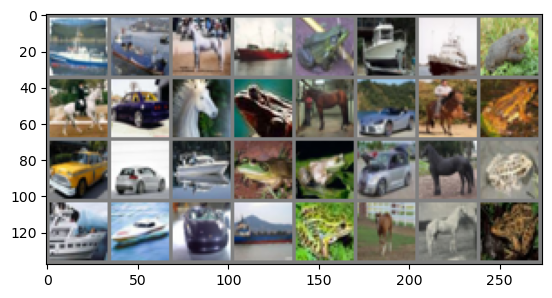

ship  ship  horse ship  frog  ship  ship  frog  horse car   horse frog  horse car   horse frog  car   car   ship  frog  frog  car   horse frog  ship  ship  car   ship  frog  horse horse frog 


In [3]:
classes = ('car', 'frog', 'horse', 'ship')
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [126]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Keep conv1 as is
        self.pool = nn.MaxPool2d(2, 2)

        # Reduce the number of output channels in conv2 slightly
        self.conv2 = nn.Conv2d(6, 16, 5)  # Adjust conv2 to 11 output channels

        # Adjust the fully connected layers slightly to reduce parameters
        self.fc1 = nn.Linear(16 * 5 * 5, 128)  # Adjust fc1 to 110 output units
        self.fc2 = nn.Linear(128, 64)  # Adjust fc2 to 55 output units
        self.fc3 = nn.Linear(64, 4)  # Keep fc3 as is

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [127]:
# Number of learnable parameters in the model
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)

62716


In [128]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [129]:
def accuracy(net, test=False):
  # Let's test on the whole test-set
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  dataloader = testloader if test else trainloader
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          # calculate outputs by running images through the network
          outputs = net(images)
          loss = criterion(outputs, labels)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = 100 * correct // total
  # print(f'Accuracy of the network on the {"test" if test else "train"} images: {100 * correct // total} %')
  return accuracy, loss.item()


In [130]:
n_epochs = 100
train_accuracy = []
test_accuracy = []
train_losses = []
test_losses = []
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    n_samples = len(trainloader.dataset)

    # Calculate train accuracy
    train_acc, train_loss = accuracy(net)
    train_accuracy.append(train_acc)
    train_losses.append(train_loss)

    # Calculate test accuracy
    test_acc, test_loss = accuracy(net, test=True)
    test_accuracy.append(test_acc)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Train accuracy: {train_acc}, Test accuracy: {test_acc}, Train loss: {train_loss}, Test loss: {test_loss}')

print('Finished Training')

Epoch 1, Train accuracy: 51, Test accuracy: 52, Train loss: 1.3045631647109985, Test loss: 1.3068069219589233
Epoch 2, Train accuracy: 64, Test accuracy: 64, Train loss: 0.8707682490348816, Test loss: 0.9206470251083374
Epoch 3, Train accuracy: 70, Test accuracy: 70, Train loss: 0.8144378066062927, Test loss: 0.8088474273681641
Epoch 4, Train accuracy: 75, Test accuracy: 74, Train loss: 0.4130847752094269, Test loss: 0.7518929839134216
Epoch 5, Train accuracy: 79, Test accuracy: 79, Train loss: 0.48143327236175537, Test loss: 0.5121737718582153
Epoch 6, Train accuracy: 82, Test accuracy: 81, Train loss: 0.49532946944236755, Test loss: 0.4505275785923004
Epoch 7, Train accuracy: 83, Test accuracy: 82, Train loss: 0.4738958775997162, Test loss: 0.36080706119537354
Epoch 8, Train accuracy: 85, Test accuracy: 84, Train loss: 0.9140207767486572, Test loss: 0.34079912304878235
Epoch 9, Train accuracy: 85, Test accuracy: 84, Train loss: 0.3884425759315491, Test loss: 0.3012128472328186
Epoch 

In [132]:
dir_path = './results/'

# Create a directory for the experiment
import os
os.makedirs(dir_path, exist_ok=True)

# Save the net
PATH = dir_path + 'model_62716.pth'
torch.save(net.state_dict(), PATH)

# Save the accuracy (train, test), and loss
df = pd.DataFrame({'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy, 'train_loss': train_losses, 'test_loss': test_losses})
df.to_csv(dir_path + 'results_62716.csv', index=False)

In [ ]:
print(accuracy(net, test=False))
print(accuracy(net, test=True))

(99, 3.8742987840123533e-07)
(88, 4.1450300216674805)


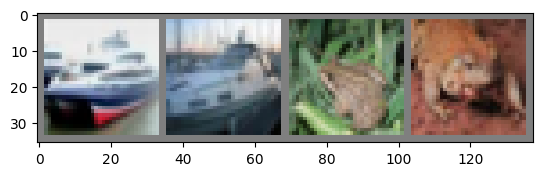

GroundTruth:  ship  ship  frog  frog 


In [ ]:
classes = ('car', 'frog', 'horse', 'ship')
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# Load the network we learned
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  car   ship  frog  frog 


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.9 %
Accuracy for class: car   is 78.6 %
Accuracy for class: bird  is 59.6 %
Accuracy for class: cat   is 31.5 %
Accuracy for class: deer  is 58.3 %
Accuracy for class: dog   is 55.0 %
Accuracy for class: frog  is 67.6 %
Accuracy for class: horse is 69.1 %
Accuracy for class: ship  is 84.2 %
Accuracy for class: truck is 57.0 %


The outcome we want:
A graph of the test error vs. the number of parameters.
We want to show the double-descent phenomenon.

Additions:
- We want to show the train-error as well - possibly on the same graph as the test error.
- A graph of the convergance time (# of epochs) vs. the number of parameters (?) Something like this. Can be nice to talk about the convergance time maybe.

The experiments that we want to do:
- We want to have at least 15 data-points (we may need more).
- So we will make at least 15 neural networks with different # of parameters approximately uniform between 10000-50000.
- For each experiment, we save the following:
  - All train and test accuracy, and loss values throughout the learning process (saved to csv file).


The order of experiments: 40 epochs of each experiments
Raz will run: From 12000 and up until 30000, with ~3000 granularity
Itay will run: From 45000 and down to 30000, with ~3000 granularity

<ipython-input-53-1916819faa2f>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(subdirs))


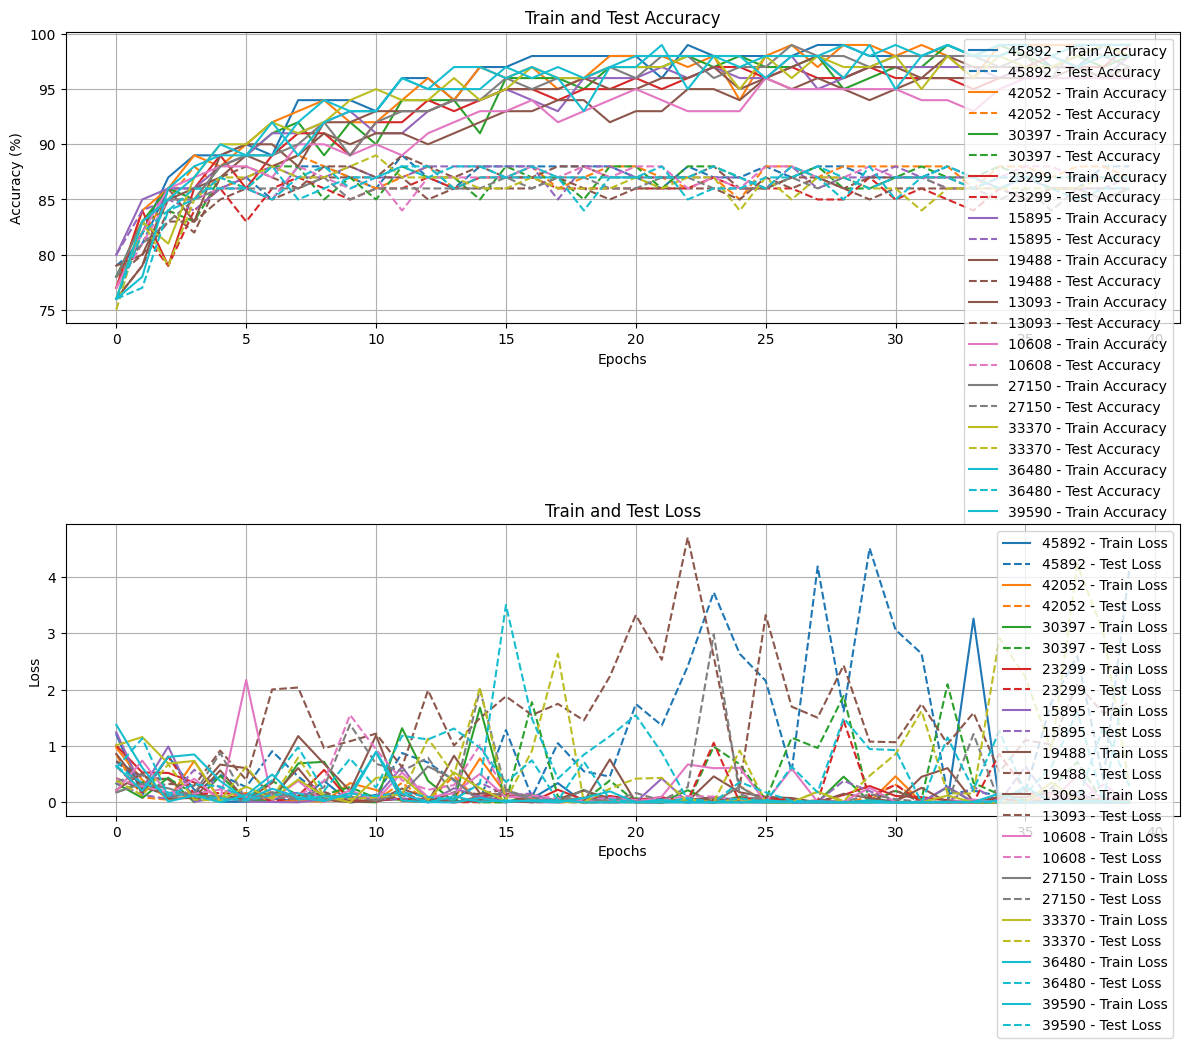

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory containing the results
directory = '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/'

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Prepare the plot
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
colors = plt.cm.get_cmap('tab10', len(subdirs))

# Iterate over each subdirectory to find and plot the CSV files
for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(directory, subdir)

    # Find the CSV files in the current subdirectory
    csv_files = [f for f in os.listdir(subdir_path) if f.endswith('.csv')]

    # Process each CSV file
    for csv_file in csv_files:
        file_path = os.path.join(subdir_path, csv_file)
        df = pd.read_csv(file_path)

        # Plot accuracy
        axs[0].plot(df['train_accuracy'], label=f'{subdir} - Train Accuracy', color=colors(i), linestyle='-')
        axs[0].plot(df['test_accuracy'], label=f'{subdir} - Test Accuracy', color=colors(i), linestyle='--')

        # Plot loss
        axs[1].plot(df['train_loss'], label=f'{subdir} - Train Loss', color=colors(i), linestyle='-')
        axs[1].plot(df['test_loss'], label=f'{subdir} - Test Loss', color=colors(i), linestyle='--')

# Customize the plots
axs[0].set_title('Train and Test Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='best')
axs[0].grid(True)

axs[1].set_title('Train and Test Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='best')
axs[1].grid(True)

plt.tight_layout()
plt.show()


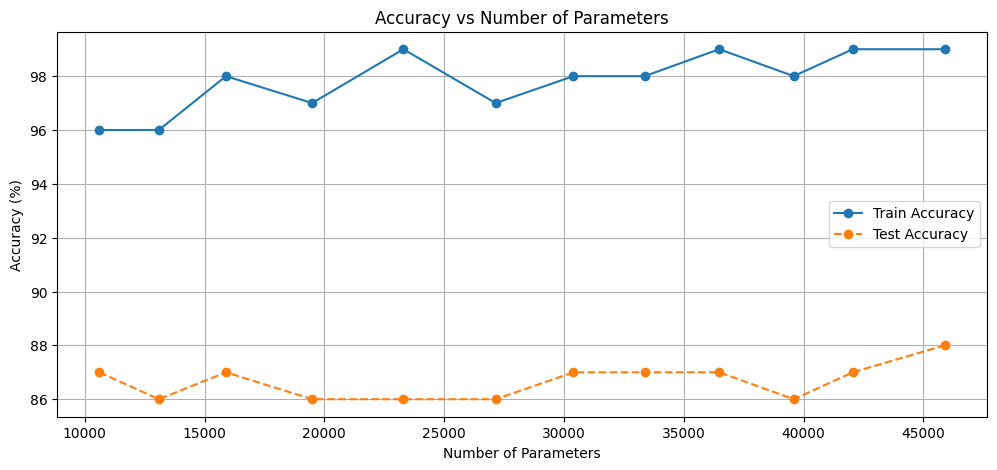

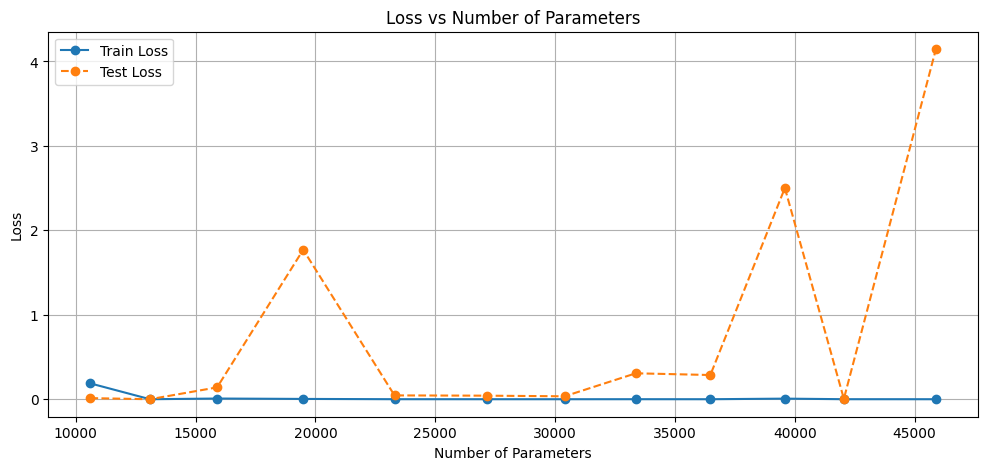

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory containing the results
directory = '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/'

# Prepare lists to collect data
param_counts = []
final_train_accuracies = []
final_test_accuracies = []
final_train_losses = []
final_test_losses = []

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)

    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
        param_counts.append(num_params)
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue

    # Find the CSV file in the current subdirectory
    csv_files = [f for f in os.listdir(subdir_path) if f.endswith('.csv')]

    # There should be exactly one CSV file per folder; process it
    if len(csv_files) == 1:
        file_path = os.path.join(subdir_path, csv_files[0])
        df = pd.read_csv(file_path)

        # Extract the final epoch's metrics
        final_train_accuracies.append(df['train_accuracy'].iloc[-1])
        final_test_accuracies.append(df['test_accuracy'].iloc[-1])
        final_train_losses.append(df['train_loss'].iloc[-1])
        final_test_losses.append(df['test_loss'].iloc[-1])

# Sort the results by the number of parameters
sorted_indices = sorted(range(len(param_counts)), key=lambda i: param_counts[i])
param_counts = [param_counts[i] for i in sorted_indices]
final_train_accuracies = [final_train_accuracies[i] for i in sorted_indices]
final_test_accuracies = [final_test_accuracies[i] for i in sorted_indices]
final_train_losses = [final_train_losses[i] for i in sorted_indices]
final_test_losses = [final_test_losses[i] for i in sorted_indices]

# Plotting Accuracy vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.plot(param_counts, final_train_accuracies, 'o-', label='Train Accuracy')
plt.plot(param_counts, final_test_accuracies, 'o--', label='Test Accuracy')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plotting Loss vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.plot(param_counts, final_train_losses, 'o-', label='Train Loss')
plt.plot(param_counts, final_test_losses, 'o--', label='Test Loss')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.title('Loss vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Define the directory containing the results
directory = '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/'

# Prepare lists to collect data
param_counts = []
final_train_accuracies = []
final_test_accuracies = []
final_train_losses = []
final_test_losses = []

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)

    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
        param_counts.append(num_params)
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue

    # Find the CSV file in the current subdirectory
    csv_files = [f for f in os.listdir(subdir_path) if f.endswith('.csv')]

    # There should be exactly one CSV file per folder; process it
    if len(csv_files) == 1:
        file_path = os.path.join(subdir_path, csv_files[0])
        df = pd.read_csv(file_path)

        # Extract the final epoch's metrics
        final_train_accuracies.append(100 - df['train_accuracy'].max())
        final_test_accuracies.append((100 - df['test_accuracy'][-10:].mean()) / 100)
        final_train_losses.append(df['train_loss'].min())
        final_test_losses.append(df['test_loss'].min())

# Sort the results by the number of parameters
sorted_indices = sorted(range(len(param_counts)), key=lambda i: param_counts[i])
param_counts = np.array([param_counts[i] for i in sorted_indices])
final_train_accuracies = [final_train_accuracies[i] for i in sorted_indices]
final_test_accuracies = [final_test_accuracies[i] for i in sorted_indices]
final_train_losses = [final_train_losses[i] for i in sorted_indices]
final_test_losses = [final_test_losses[i] for i in sorted_indices]
# Interpolation
param_range = np.linspace(param_counts.min(), param_counts.max(), 500)  # Generate a smooth range of parameter values

train_accuracy_spline = CubicSpline(param_counts, final_train_accuracies)
test_accuracy_spline = CubicSpline(param_counts, final_test_accuracies)

train_loss_spline = CubicSpline(param_counts, final_train_losses)
test_loss_spline = CubicSpline(param_counts, final_test_losses)
# Plotting Accuracy vs Number of Parameters
plt.figure(figsize=(12, 5))
# plt.plot(param_counts, final_train_accuracies, 'o-', label='Train Accuracy')
plt.plot(param_range, test_accuracy_spline(param_range), 'o--', label='Test Error')
plt.xlabel('Number of Parameters')
plt.ylabel('Error')
plt.title('Accuracy vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plotting Loss vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.ylim(0,0.05)
plt.plot(param_counts, final_train_losses, 'o-', label='Train Loss', )
plt.plot(param_counts, final_test_losses, 'o--', label='Test Loss')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.title('Loss vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()


IndexError: list index out of range

13K, 33k, 36k, 39k 45K - more epochs, around 30 more
new data points - 8K, 5K, 3K, 21.5K, 24.5K 50 epochs

In [103]:
def Net_36480():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 10, 5)
            self.fc1 = nn.Linear(10 * 5 * 5, 110)
            self.fc2 = nn.Linear(110, 60)
            self.fc3 = nn.Linear(60, 4)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()
    
def Net_10608():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 6, 5)  # Conv layer with 6 output channels
            self.fc1 = nn.Linear(6 * 5 * 5, 40)  # Fully connected layer
            self.fc2 = nn.Linear(40, 20)  # Fully connected layer
            self.fc3 = nn.Linear(20, 4)   # Fully connected layer

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)  # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()

def Net_13093():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 8, 5)
            self.fc1 = nn.Linear(8 * 5 * 5, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, 4)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()
    
def Net_15895():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 8, 5)  # Conv layer with 8 output channels
            self.fc1 = nn.Linear(8 * 5 * 5, 50)  # Fully connected layer
            self.fc2 = nn.Linear(50, 25)  # Fully connected layer
            self.fc3 = nn.Linear(25, 4)   # Fully connected layer

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)  # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()


def Net_39590():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 10, 5)
            self.fc1 = nn.Linear(10 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 60)
            self.fc3 = nn.Linear(60, 4)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()
    
def Net_23299():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 9, 5)  # Conv layer with 9 output channels
            self.fc1 = nn.Linear(9 * 5 * 5, 80)  # Fully connected layer
            self.fc2 = nn.Linear(80, 40)  # Fully connected layer
            self.fc3 = nn.Linear(40, 4)   # Fully connected layer

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)  # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()

def Net_27150():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Conv layer with 6 output channels
            self.pool = nn.MaxPool2d(2, 2)   # Max pooling layer with 2x2 window
            self.conv2 = nn.Conv2d(6, 10, 5)  # Conv layer with 10 output channels
            self.fc1 = nn.Linear(10 * 5 * 5, 80)  # Fully connected layer
            self.fc2 = nn.Linear(80, 60)  # Fully connected layer
            self.fc3 = nn.Linear(60, 4)   # Fully connected layer

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)  # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()

def Net_45892():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 12, 5)
            self.fc1 = nn.Linear(12 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 60)
            self.fc3 = nn.Linear(60, 4)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()

def Net_42052():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 12, 5)
            self.fc1 = nn.Linear(12 * 5 * 5, 110)
            self.fc2 = nn.Linear(110, 58)
            self.fc3 = nn.Linear(58, 4)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()

def Net_30397():
  class Net(nn.Module):
      def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d(3, 6, 5)
          self.pool = nn.MaxPool2d(2, 2)
          self.conv2 = nn.Conv2d(6, 10, 5)
          self.fc1 = nn.Linear(10 * 5 * 5, 92)
          self.fc2 = nn.Linear(92, 55)
          self.fc3 = nn.Linear(55, 4)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x
  return Net()


def Net_33370():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 10, 5)
            self.fc1 = nn.Linear(10 * 5 * 5, 100)
            self.fc2 = nn.Linear(100, 60)
            self.fc3 = nn.Linear(60, 4)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return Net()

def Net_16819():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Keep conv1 as is
            self.pool = nn.MaxPool2d(2, 2)
    
            # Reduce the number of output channels in conv2 slightly
            self.conv2 = nn.Conv2d(6, 9, 5)  # Adjust conv2 to 11 output channels
    
            # Adjust the fully connected layers slightly to reduce parameters
            self.fc1 = nn.Linear(9 * 5 * 5, 80)  # Adjust fc1 to 110 output units
            self.fc2 = nn.Linear(80, 40)  # Adjust fc2 to 55 output units
            self.fc3 = nn.Linear(40, 4)  # Keep fc3 as is
    
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)  # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    return Net()

def Net_3305():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Keep conv1 as is
            self.pool = nn.MaxPool2d(2, 2)
    
            # Reduce the number of output channels in conv2 slightly
            self.conv2 = nn.Conv2d(6, 5, 5)  # Adjust conv2 to 11 output channels
    
            # Adjust the fully connected layers slightly to reduce parameters
            self.fc1 = nn.Linear(5 * 5 * 5, 23)  # Adjust fc1 to 110 output units
            self.fc2 = nn.Linear(23, 8)  # Adjust fc2 to 55 output units
            self.fc3 = nn.Linear(8, 4)  # Keep fc3 as is
    
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)  # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    return Net()

def Net_5695():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Keep conv1 as is
            self.pool = nn.MaxPool2d(2, 2)
    
            # Reduce the number of output channels in conv2 slightly
            self.conv2 = nn.Conv2d(6, 5, 5)  # Adjust conv2 to 11 output channels
    
            # Adjust the fully connected layers slightly to reduce parameters
            self.fc1 = nn.Linear(5 * 5 * 5, 30)  # Adjust fc1 to 110 output units
            self.fc2 = nn.Linear(30, 20)  # Adjust fc2 to 55 output units
            self.fc3 = nn.Linear(20, 4)  # Keep fc3 as is
    
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)  # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    return Net()

def Net_62716():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Keep conv1 as is
            self.pool = nn.MaxPool2d(2, 2)
    
            # Reduce the number of output channels in conv2 slightly
            self.conv2 = nn.Conv2d(6, 16, 5)  # Adjust conv2 to 11 output channels
    
            # Adjust the fully connected layers slightly to reduce parameters
            self.fc1 = nn.Linear(16 * 5 * 5, 128)  # Adjust fc1 to 110 output units
            self.fc2 = nn.Linear(128, 64)  # Adjust fc2 to 55 output units
            self.fc3 = nn.Linear(64, 4)  # Keep fc3 as is
    
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)  # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    return Net()
net = Net()
# Mapping from parameter count to the corresponding network definition
models_to_train = {
    10608: Net_10608,
    36480: Net_36480,
    15895: Net_15895,
    16819: Net_16819,
    45892: Net_45892,
    30397: Net_30397,
    27150: Net_27150,
    3305: Net_3305,
    23299: Net_23299,
    5695: Net_5695,
    42052: Net_42052,
}


In [104]:
models_to_train = {
    10608: {'net': Net_10608, 'epochs': 50},
    36480: {'net': Net_36480, 'epochs': 50},
    15895: {'net': Net_15895, 'epochs': 50},
    16819: {'net': Net_16819, 'epochs': 50},
    45892: {'net': Net_45892, 'epochs': 50},
    30397: {'net': Net_30397, 'epochs': 50},
    27150: {'net': Net_27150, 'epochs': 50},
    3305: {'net': Net_3305, 'epochs': 50},
    23299: {'net': Net_23299, 'epochs': 50},
    5695: {'net': Net_5695, 'epochs': 50},
    42052: {'net': Net_42052, 'epochs': 50},
}

# Directory to save the models and results
os.makedirs('result_noise', exist_ok=True)
# Function to add noise to the labels
def add_label_noise(labels, noise_ratio=0.15, num_classes=4):
    noisy_labels = labels.clone()
    num_noisy = int(noise_ratio * len(labels))
    
    # Randomly select indices to corrupt
    noisy_indices = np.random.choice(len(labels), num_noisy, replace=False)
    
    # Replace the selected labels with random classes
    noisy_labels[noisy_indices] = torch.randint(0, num_classes, size=(num_noisy,))
    
    return noisy_labels

# Training function
def train_model(model, trainloader, testloader, criterion, optimizer, n_epochs, save_path):
    model.train()
    train_accuracy = []
    test_accuracy = []
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # Add noise to the labels
            noisy_labels = add_label_noise(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, noisy_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate and store train and test accuracy/loss
        train_acc, train_loss = calculate_accuracy_and_loss(model, trainloader, criterion)
        test_acc, test_loss = calculate_accuracy_and_loss(model, testloader, criterion, test=True)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}, Train accuracy: {train_acc}, Test accuracy: {test_acc}, Train loss: {train_loss}, Test loss: {test_loss}')

    # Save the model after training
    new_model_path = os.path.join('result_noise', save_path.replace('.pth', '_noisy.pth'))
    torch.save(model.state_dict(), new_model_path)

    # Save the results as a CSV
    new_results_path = os.path.join('result_noise', save_path.replace('.pth', '_noisy_results.csv'))
    results = pd.DataFrame({
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss': train_losses,
        'test_loss': test_losses
    })
    results.to_csv(new_results_path, index=False)
    print(f'Saved model to {new_model_path} and results to {new_results_path}')

def calculate_accuracy_and_loss(model, dataloader, criterion, test=False):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    avg_loss = running_loss / len(dataloader)
    return accuracy, avg_loss

# Initialize the loss function
criterion = nn.CrossEntropyLoss()

# Iterate over each model, create it from scratch, and train it with noisy labels
for key, model_info in models_to_train.items():
    print(f"Processing model with {key} parameters")

    # Instantiate the model using the correct architecture
    model = model_info['net']()  # Call the function to create the network
    
    # Initialize the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.90)

    # Train the model from scratch
    train_model(model, trainloader, testloader, criterion, optimizer, model_info['epochs'], f'model_{key}.pth')


Processing model with 10608 parameters
Epoch 1, Train accuracy: 33, Test accuracy: 33, Train loss: 1.3645551441192627, Test loss: 1.3647582654953003
Epoch 2, Train accuracy: 53, Test accuracy: 53, Train loss: 1.1282921803474426, Test loss: 1.1329880690574645
Epoch 3, Train accuracy: 64, Test accuracy: 63, Train loss: 0.9079576915740967, Test loss: 0.9094859318733215
Epoch 4, Train accuracy: 70, Test accuracy: 70, Train loss: 0.7874336826324463, Test loss: 0.7865893244743347
Epoch 5, Train accuracy: 75, Test accuracy: 75, Train loss: 0.6971059621334076, Test loss: 0.6951026465892792
Epoch 6, Train accuracy: 76, Test accuracy: 75, Train loss: 0.6556938942909241, Test loss: 0.65824556016922
Epoch 7, Train accuracy: 79, Test accuracy: 78, Train loss: 0.6099262264728547, Test loss: 0.6151877450942993
Epoch 8, Train accuracy: 80, Test accuracy: 79, Train loss: 0.5684318134784698, Test loss: 0.5749989323616028
Epoch 9, Train accuracy: 81, Test accuracy: 80, Train loss: 0.5371436105251313, Tes

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import os
import pandas as pd

# Define the paths and number of additional epochs for each model
models_to_train = {
    # '13093': {'path': '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/13093/model_13093.pth', 'additional_epochs': 30},
    # '33370': {'path': '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/33370/model_33370.pth', 'additional_epochs': 30},
    # '36480': {'path': '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/36480/model_36480.pth', 'additional_epochs': 30},
    # '39590': {'path': '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/39590/model_39590.pth', 'additional_epochs': 30},
    # '45892': {'path': '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/45892/model_45892.pth', 'additional_epochs': 30}
    '30397' : {'path': '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/30397/model_30397.pth', 'additional_epochs': 30}
}


# Training function
def train_model(model, trainloader, testloader, criterion, optimizer, n_epochs, save_path):
    model.train()
    train_accuracy = []
    test_accuracy = []
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate and store train and test accuracy/loss
        train_acc, train_loss = calculate_accuracy_and_loss(model, trainloader, criterion)
        test_acc, test_loss = calculate_accuracy_and_loss(model, testloader, criterion, test=True)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}, Train accuracy: {train_acc}, Test accuracy: {test_acc}, Train loss: {train_loss}, Test loss: {test_loss}')

    # Save the model after training with a new name
    new_model_path = save_path.replace('.pth', '_retrained.pth')
    torch.save(model.state_dict(), new_model_path)

    # Save the results as a CSV with a new name
    new_results_path = save_path.replace('.pth', '_retrained_results.csv')
    results = pd.DataFrame({
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss': train_losses,
        'test_loss': test_losses
    })
    results.to_csv(new_results_path, index=False)
    print(f'Saved model to {new_model_path} and results to {new_results_path}')

def calculate_accuracy_and_loss(model, dataloader, criterion, test=False):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    avg_loss = running_loss / len(dataloader)
    return accuracy, avg_loss

# Initialize the loss function
criterion = nn.CrossEntropyLoss()

# Iterate over each model, load it, and continue training
for key, model_info in models_to_train.items():
    print(f"Processing model with {key} parameters")

    # Convert the key to an integer and use it to get the correct Net class
    param_count = int(key)
    model = net_dict[param_count]()
    print(model_info['path'])
    # Load the state dictionary into the instantiated model
    model.load_state_dict(torch.load(model_info['path']))

    # Initialize the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.90)

    # Continue training the model for the additional epochs
    train_model(model, trainloader, testloader, criterion, optimizer, model_info['additional_epochs'], model_info['path'])


Processing model with 30397 parameters
/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/30397/model_30397.pth
Epoch 1, Train accuracy: 98, Test accuracy: 87, Train loss: 0.035598756445512324, Test loss: 0.7568474748632334
Epoch 2, Train accuracy: 94, Test accuracy: 84, Train loss: 0.24157531213099104, Test loss: 1.0534898524254654
Epoch 3, Train accuracy: 98, Test accuracy: 87, Train loss: 0.03669098797955647, Test loss: 0.7768107839949946
Epoch 4, Train accuracy: 99, Test accuracy: 88, Train loss: 0.016726812045806904, Test loss: 0.7633704239181375
Epoch 5, Train accuracy: 99, Test accuracy: 88, Train loss: 0.019717828860185638, Test loss: 0.8383932733936044
Epoch 6, Train accuracy: 98, Test accuracy: 86, Train loss: 0.05387465762570256, Test loss: 0.8861739458082423
Epoch 7, Train accuracy: 99, Test accuracy: 87, Train loss: 0.026015651077619713, Test loss: 0.8603814584868211
Epoch 8, Train accuracy: 99, Test accuracy: 87, Train loss: 0.024897176385179888, Test loss: 0.9551

In [109]:
import os

folder_list = [
    "10608",
    "15895",
    "23299",
    "27150",
    "30397",
    "3305",
    "42052",
    "45892",
    "5695",
]
# Define the base path to the 'results' directory
results_folder_path = './result_noise/'  # Adjust this path to your actual directory

# Iterate over each folder name in the list and create the folders
for folder_name in folder_list:
    # Construct the full path for the new folder
    folder_path = os.path.join(results_folder_path, folder_name)
    
    # Create the folder
    os.makedirs(folder_path, exist_ok=True)  # 'exist_ok=True' ensures no error if the folder already exists

    # Print confirmation
    print(f"Folder created: {folder_path}")



Folder created: ./result_noise/10608
Folder created: ./result_noise/15895
Folder created: ./result_noise/23299
Folder created: ./result_noise/27150
Folder created: ./result_noise/30397
Folder created: ./result_noise/3305
Folder created: ./result_noise/42052
Folder created: ./result_noise/45892
Folder created: ./result_noise/5695


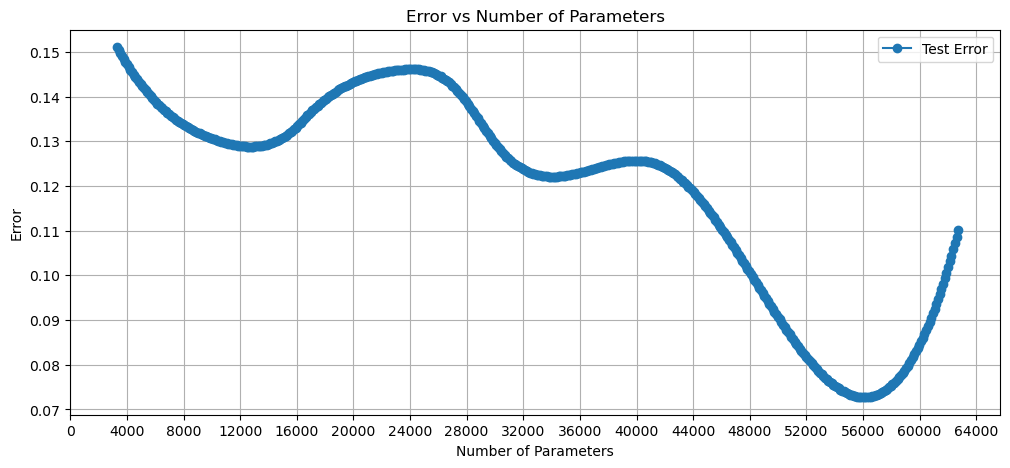

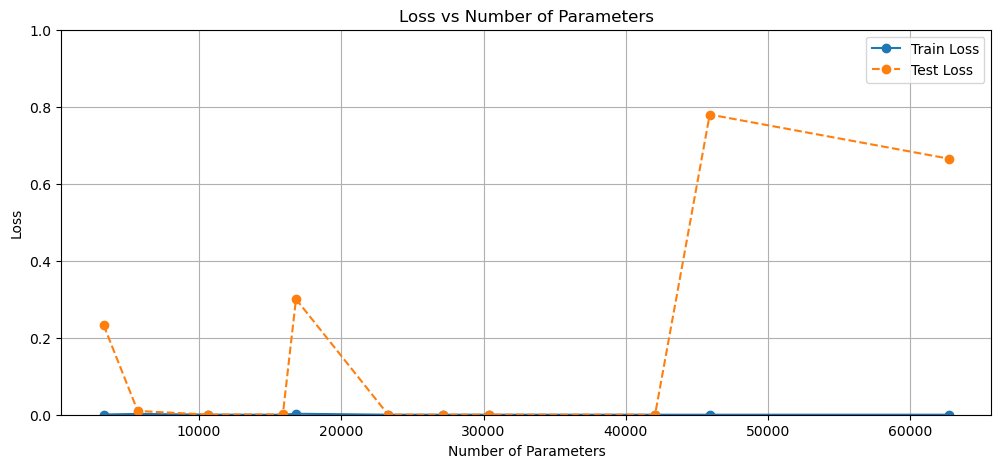

In [144]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import numpy as np

# Define the directory containing the results
directory = './results/'

# Prepare lists to collect data
param_counts = []
final_train_accuracies = []
final_test_accuracies = []
final_train_losses = []
final_test_losses = []

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)

    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
        param_counts.append(num_params)
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue

    # Check for retrained results first
    retrained_csv_path = os.path.join(subdir_path, f"model_{subdir}_retrained_results.csv")
    original_csv_path = os.path.join(subdir_path, f"results_{subdir}.csv")

    if os.path.exists(retrained_csv_path):
        csv_path = retrained_csv_path
    elif os.path.exists(original_csv_path):
        csv_path = original_csv_path
    else:
        continue  # Skip if neither file exists

    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Extract the final epoch's metrics
    final_train_accuracies.append(100 - df['train_accuracy'].max())
    final_test_accuracies.append((100 - df['test_accuracy'][-10:].mean()) / 100)
    final_train_losses.append(df['train_loss'][-30:].min())
    final_test_losses.append(df['test_loss'][-30:].min())

# Sort the results by the number of parameters
sorted_indices = sorted(range(len(param_counts)), key=lambda i: param_counts[i])
param_counts = np.array([param_counts[i] for i in sorted_indices])
final_train_accuracies = [final_train_accuracies[i] for i in sorted_indices]
final_test_accuracies = [final_test_accuracies[i] for i in sorted_indices]
final_train_losses = [final_train_losses[i] for i in sorted_indices]
final_test_losses = [final_test_losses[i] for i in sorted_indices]

# Interpolation
param_range = np.linspace(param_counts.min()-10, param_counts.max()+10, 500)  # Generate a smooth range of parameter values

train_accuracy_spline = CubicSpline(param_counts, final_train_accuracies)
test_accuracy_spline = CubicSpline(param_counts, final_test_accuracies)

train_loss_spline = CubicSpline(param_counts, final_train_losses)
test_loss_spline = CubicSpline(param_counts, final_test_losses)

# Plotting Accuracy vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.plot(param_range, test_accuracy_spline(param_range), 'o-', label='Test Error')
x_ticks = np.arange(0, param_counts.max() + 4000, 4000)  # Adjust the 2000 to whatever interval you want
plt.xticks(x_ticks)
plt.xlabel('Number of Parameters')
plt.ylabel('Error')
plt.title('Error vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plotting Loss vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.ylim(0, 1)
plt.plot(param_counts, final_train_losses, 'o-', label='Train Loss')
plt.plot(param_counts, final_test_losses, 'o--', label='Test Loss')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.title('Loss vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()


['.ipynb_checkpoints', '16819', '36480', '10608', '15895', '23299', '27150', '30397', '3305', '42052', '45892', '5695']
Param_counts: 16819
train_accuracy:
[52 65 72 74 77 78 80 80 80 82 83 83 84 84 83 83 86 86 87 87 88 88 87 89
 89 89 90 90 89 91 90 91 91 90 90 92 90 91 92 92 92 90 92 92 93 93 93 93
 93 93]
Param_counts: 36480
train_accuracy:
[46 55 66 72 77 81 82 83 82 85 85 86 87 86 87 88 88 88 88 89 89 87 89 90
 89 90 91 88 90 91 90 91 92 92 92 92 91 93 93 92 93 92 93 93 93 94 94 94
 93 94]
Param_counts: 10608
train_accuracy:
[33 53 64 70 75 76 79 80 81 82 83 81 83 83 85 84 83 85 86 84 85 87 86 87
 88 87 88 87 88 88 89 88 89 89 89 89 89 89 89 90 90 89 90 90 90 91 90 91
 91 91]
Param_counts: 15895
train_accuracy:
[35 49 62 71 75 78 80 80 83 82 84 85 86 85 86 86 87 88 86 88 87 88 88 89
 88 89 90 89 89 90 90 89 89 90 91 91 90 90 91 91 91 91 92 91 92 92 92 92
 92 93]
Param_counts: 23299
train_accuracy:
[47 61 69 76 77 80 81 81 82 82 84 84 86 85 86 87 86 87 88 88 89 88 89 88
 89 88 89 9

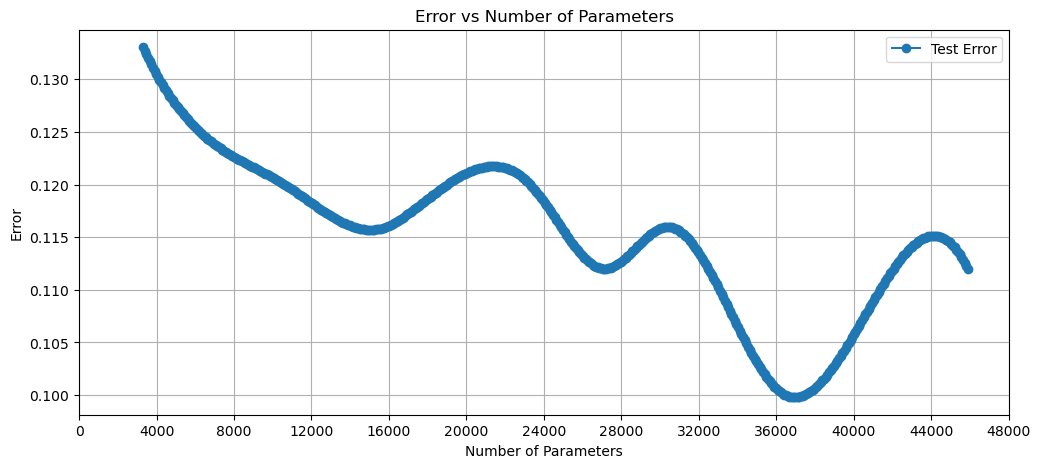

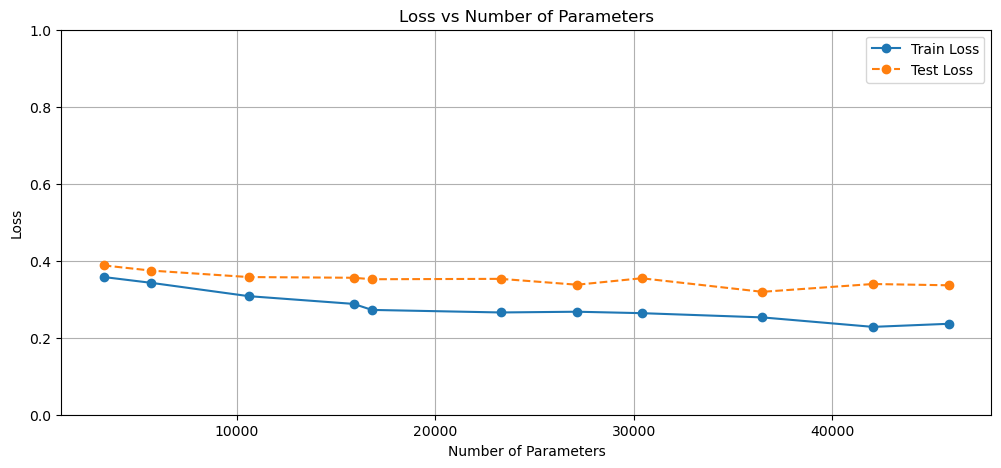

In [139]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import numpy as np

# Define the directory containing the results
directory = './result_noise/'

# Prepare lists to collect data
param_counts = []
final_train_accuracies = []
final_test_accuracies = []
final_train_losses = []
final_test_losses = []

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
print(subdirs)

# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)

    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
        param_counts.append(num_params)
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue
    print(f'Param_counts: {num_params}')

    # Check for retrained results first
    retrained_csv_path = os.path.join(subdir_path, f"model_{subdir}_retrained_results.csv")
    original_csv_path = os.path.join(subdir_path, f"model_{subdir}_noisy_results.csv")

    if os.path.exists(retrained_csv_path):
        csv_path = retrained_csv_path
    elif os.path.exists(original_csv_path):
        csv_path = original_csv_path
    else:
        continue  # Skip if neither file exists

    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Print train_accuracy values for debugging
    print('train_accuracy:')
    print(df['train_accuracy'].values)  # Use .values to print the actual content

    # Extract the final epoch's metrics
    final_train_accuracies.append(100 - df['train_accuracy'].max())
    final_test_accuracies.append((100 - df['test_accuracy'][-10:].mean()) / 100)
    final_train_losses.append(df['train_loss'][-30:].min())
    final_test_losses.append(df['test_loss'][-30:].min())


# Sort the results by the number of parameters
sorted_indices = sorted(range(len(param_counts)), key=lambda i: param_counts[i])
param_counts = np.array([param_counts[i] for i in sorted_indices])
print(sorted_indices)
print(final_train_accuracies)
final_train_accuracies = [final_train_accuracies[i] for i in sorted_indices]
final_test_accuracies = [final_test_accuracies[i] for i in sorted_indices]
final_train_losses = [final_train_losses[i] for i in sorted_indices]
final_test_losses = [final_test_losses[i] for i in sorted_indices]

# Interpolation
param_range = np.linspace(param_counts.min()-10, param_counts.max()+10, 500)  # Generate a smooth range of parameter values

train_accuracy_spline = CubicSpline(param_counts, final_train_accuracies)
test_accuracy_spline = CubicSpline(param_counts, final_test_accuracies)

train_loss_spline = CubicSpline(param_counts, final_train_losses)
test_loss_spline = CubicSpline(param_counts, final_test_losses)

# Plotting Accuracy vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.plot(param_range, test_accuracy_spline(param_range), 'o-', label='Test Error')
x_ticks = np.arange(0, param_counts.max() + 4000, 4000)  # Adjust the 2000 to whatever interval you want
plt.xticks(x_ticks)
plt.xlabel('Number of Parameters')
plt.ylabel('Error')
plt.title('Error vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plotting Loss vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.ylim(0, 1)
plt.plot(param_counts, final_train_losses, 'o-', label='Train Loss')
plt.plot(param_counts, final_test_losses, 'o--', label='Test Loss')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.title('Loss vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import numpy as np

# Mapping from parameter count to the corresponding network definition
net_dict = {
    10608: Net_10608,
    36480: Net_36480,
    15895: Net_15895,
    16819: Net_16819,
    45892: Net_45892,
    30397: Net_30397,
    27150: Net_27150,
    3305: Net_3305,
    23299: Net_23299,
    5695: Net_5695,
    42052: Net_42052,
}

# Define the paths and number of epochs for each model
models_to_train = {
    '10608': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/10608/model_10608_noisy.pth', 'epochs': 50},
    '36480': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/36480/model_36480_noisy.pth', 'epochs': 50},
    '15895': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/15895/model_15895_noisy.pth', 'epochs': 50},
    '16819': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/16819/model_16819_noisy.pth', 'epochs': 50},
    '45892': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/45892/model_45892_noisy.pth', 'epochs': 50},
    '30397': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/30397/model_30397_noisy.pth', 'epochs': 50},
    '27150': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/10608/model_10608_noisy.pth', 'epochs': 50},
    '3305': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/36480/model_36480_noisy.pth', 'epochs': 50},
    '42052': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/15895/model_15895_noisy.pth', 'epochs': 50},
    '5695': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/16819/model_16819_noisy.pth', 'epochs': 50},
    '23299': {'path': '/cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/30397/model_30397_noisy.pth', 'epochs': 50}
}

# Directory to save the retrained models and results
os.makedirs('result_retrain_noise', exist_ok=True)

# Function to add noise to the labels
def add_label_noise(labels, noise_ratio=0.15, num_classes=4):
    noisy_labels = labels.clone()
    num_noisy = int(noise_ratio * len(labels))
    
    # Randomly select indices to corrupt
    noisy_indices = np.random.choice(len(labels), num_noisy, replace=False)
    
    # Replace the selected labels with random classes
    noisy_labels[noisy_indices] = torch.randint(0, num_classes, size=(num_noisy,))
    
    return noisy_labels

# Training function
def train_model(model, trainloader, testloader, criterion, optimizer, n_epochs, save_path):
    model.train()
    train_accuracy = []
    test_accuracy = []
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # Add noise to the labels
            noisy_labels = add_label_noise(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, noisy_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate and store train and test accuracy/loss
        train_acc, train_loss = calculate_accuracy_and_loss(model, trainloader, criterion)
        test_acc, test_loss = calculate_accuracy_and_loss(model, testloader, criterion, test=True)

        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}, Train accuracy: {train_acc}, Test accuracy: {test_acc}, Train loss: {train_loss}, Test loss: {test_loss}')

    # Save the model after training with a new name
    new_model_path = os.path.join('result_retrain_noise', save_path.replace('.pth', '_retrained.pth'))
    torch.save(model.state_dict(), new_model_path)

    # Save the results as a CSV
    new_results_path = os.path.join('result_retrain_noise', save_path.replace('.pth', '_retrained_results.csv'))
    results = pd.DataFrame({
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss': train_losses,
        'test_loss': test_losses
    })
    results.to_csv(new_results_path, index=False)
    print(f'Saved model to {new_model_path} and results to {new_results_path}')

def calculate_accuracy_and_loss(model, dataloader, criterion, test=False):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    avg_loss = running_loss / len(dataloader)
    return accuracy, avg_loss

# Initialize the loss function
criterion = nn.CrossEntropyLoss()

# Load your data (assuming trainloader and testloader are already defined)
# Example of loading CIFAR-10 as your dataset. Modify as needed.
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# trainloader = torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=True, download=True, transform=transform), batch_size=32, shuffle=True)
# testloader = torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, download=True, transform=transform), batch_size=32, shuffle=False)

# Iterate over each model, load it, and retrain with noisy labels
for key, model_info in models_to_train.items():
    print(f"Processing model with {key} parameters")

    # Convert the key to an integer and use it to get the correct Net class
    param_count = int(key)
    model = net_dict[param_count]()
    
    # Load the noisy model state dictionary into the instantiated model
    print(f"Loading model from {model_info['path']}")
    model.load_state_dict(torch.load(model_info['path']))

    # Initialize the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.90)

    # Continue training the model with label noise for the additional epochs
    train_model(model, trainloader, testloader, criterion, optimizer, model_info['epochs'], model_info['path'])


Processing model with 10608 parameters
Loading model from /cs_storage/itayab/PyCharmProjects/Rethinking_Generalization/src/result_noise/10608/model_10608_noisy.pth
Epoch 1, Train accuracy: 91, Test accuracy: 88, Train loss: 0.3175206609010696, Test loss: 0.3690771880149841
Epoch 2, Train accuracy: 91, Test accuracy: 88, Train loss: 0.3142465338230133, Test loss: 0.3713328948020935
Epoch 3, Train accuracy: 91, Test accuracy: 88, Train loss: 0.32513926129341125, Test loss: 0.3763104408979416
Epoch 4, Train accuracy: 89, Test accuracy: 87, Train loss: 0.3305875770688057, Test loss: 0.38212105953693387
Epoch 5, Train accuracy: 91, Test accuracy: 89, Train loss: 0.30890186067819597, Test loss: 0.36343024563789367
Epoch 6, Train accuracy: 91, Test accuracy: 88, Train loss: 0.312940655875206, Test loss: 0.36693082320690157
Epoch 7, Train accuracy: 89, Test accuracy: 86, Train loss: 0.3485663153409958, Test loss: 0.4053375449180603
Epoch 8, Train accuracy: 90, Test accuracy: 87, Train loss: 0.

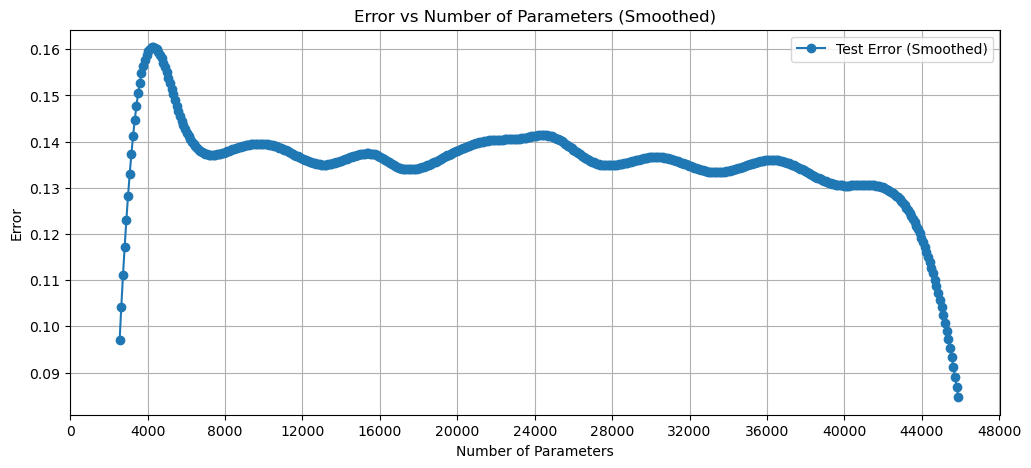

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import numpy as np

# Define the directory containing the results
directory = './results/'

# Prepare lists to collect data
param_counts = []
final_train_accuracies = []
final_test_accuracies = []
final_train_losses = []
final_test_losses = []

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)

    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
        param_counts.append(num_params)
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue

    # Check for retrained results first
    retrained_csv_path = os.path.join(subdir_path, f"model_{subdir}_retrained_results.csv")
    original_csv_path = os.path.join(subdir_path, f"results_{subdir}.csv")

    if os.path.exists(retrained_csv_path):
        csv_path = retrained_csv_path
    elif os.path.exists(original_csv_path):
        csv_path = original_csv_path
    else:
        continue  # Skip if neither file exists

    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Extract the final epoch's metrics
    final_train_accuracies.append(100 - df['train_accuracy'].max())
    final_test_accuracies.append((100 - df['test_accuracy'][-10:].mean()) / 100)
    final_train_losses.append(df['train_loss'][-10:].min())
    final_test_losses.append(df['test_loss'][-10:].min())

# Sort the results by the number of parameters
sorted_indices = sorted(range(len(param_counts)), key=lambda i: param_counts[i])
param_counts = np.array([param_counts[i] for i in sorted_indices])
final_train_accuracies = [final_train_accuracies[i] for i in sorted_indices]
final_test_accuracies = [final_test_accuracies[i] for i in sorted_indices]
final_train_losses = [final_train_losses[i] for i in sorted_indices]
final_test_losses = [final_test_losses[i] for i in sorted_indices]

# Smoothing the data using a moving average (convolution)
def smooth_data(data, window_size=3):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')

# Apply smoothing to the test accuracies
smoothed_test_accuracies = smooth_data(final_test_accuracies)

# Interpolation
param_range = np.linspace(param_counts.min(), param_counts.max(), 500)

train_accuracy_spline = CubicSpline(param_counts, final_train_accuracies)
test_accuracy_spline = CubicSpline(param_counts, smoothed_test_accuracies)

# Plotting Accuracy vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.plot(param_range, test_accuracy_spline(param_range), 'o-', label='Test Error (Smoothed)')
x_ticks = np.arange(0, param_counts.max() + 4000, 4000)  # Adjust the interval as needed
plt.xticks(x_ticks)
plt.xlabel('Number of Parameters')
plt.ylabel('Error')
plt.title('Error vs Number of Parameters (Smoothed)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/tmp/ipykernel_3488331/2380929590.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


  Param_Count Final_Train_Accuracy  Final_Test_Accuracy  Final_Train_Loss  \
0        3305                    9                0.151          0.000499   
1        5695                    6                0.140          0.002174   
2       10608                    4                0.130          0.000083   
3       15895                    2                0.133          0.000007   
4       16819                    2                0.136          0.002522   
5       23299                    1                0.146          0.000049   
6       27150                    1                0.142          0.000006   
7       30397                    1                0.128          0.000003   
8       42052                    1                0.124          0.000006   
9       45892                    0                0.111          0.000027   

   Final_Test_Loss  
0         0.232542  
1         0.009830  
2         0.000302  
3         0.000651  
4         0.300267  
5         0.000009  
6    

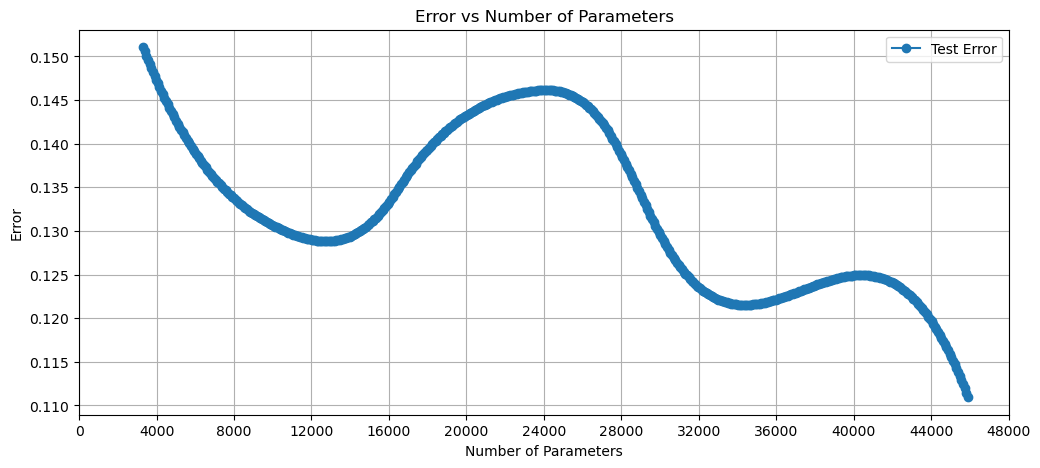

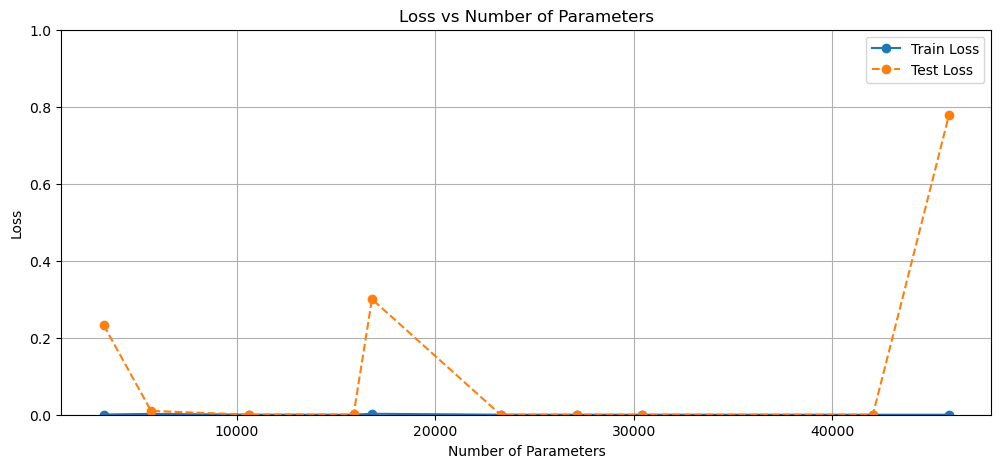

In [138]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import numpy as np

# Define the directory containing the results
directory = './results/'

# Prepare a DataFrame to aggregate all results
results_df = pd.DataFrame(columns=['Param_Count', 'Final_Train_Accuracy', 'Final_Test_Accuracy', 'Final_Train_Loss', 'Final_Test_Loss'])

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)

    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue

    # Check for retrained results first
    retrained_csv_path = os.path.join(subdir_path, f"model_{subdir}_retrained_results.csv")
    original_csv_path = os.path.join(subdir_path, f"results_{subdir}.csv")

    if os.path.exists(retrained_csv_path):
        csv_path = retrained_csv_path
    elif os.path.exists(original_csv_path):
        csv_path = original_csv_path
    else:
        continue  # Skip if neither file exists

    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Extract the final epoch's metrics
    final_train_accuracy = 100 - df['train_accuracy'].max()
    final_test_accuracy = (100 - df['test_accuracy'][-10:].mean()) / 100
    final_train_loss = df['train_loss'][-30:].min()
    final_test_loss = df['test_loss'][-30:].min()

    # Create a temporary DataFrame to hold the new row
    temp_df = pd.DataFrame({
        'Param_Count': [num_params],
        'Final_Train_Error': [final_train_accuracy],
        'Final_Test_Error': [final_test_accuracy],
        'Final_Train_Loss': [final_train_loss],
        'Final_Test_Loss': [final_test_loss]
    })

    # Use pd.concat to add the new row to the DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Sort the DataFrame by Param_Count
results_df = results_df.sort_values(by='Param_Count').reset_index(drop=True)

# Save the combined results to a new CSV file
results_df.to_csv('combined_results.csv', index=False)

# Print the combined results DataFrame to verify
print(results_df)

# Optional: You can continue plotting based on the aggregated DataFrame.
param_counts = results_df['Param_Count'].values
final_train_accuracies = results_df['Final_Train_Error'].values
final_test_accuracies = results_df['Final_Test_Error'].values
final_train_losses = results_df['Final_Train_Loss'].values
final_test_losses = results_df['Final_Test_Loss'].values

# Interpolation for smooth plotting
param_range = np.linspace(param_counts.min() - 10, param_counts.max() + 10, 500)

train_accuracy_spline = CubicSpline(param_counts, final_train_accuracies)
test_accuracy_spline = CubicSpline(param_counts, final_test_accuracies)

train_loss_spline = CubicSpline(param_counts, final_train_losses)
test_loss_spline = CubicSpline(param_counts, final_test_losses)

# Plotting Accuracy vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.plot(param_range, test_accuracy_spline(param_range), 'o-', label='Test Error')
plt.xticks(np.arange(0, param_counts.max() + 4000, 4000))
plt.xlabel('Number of Parameters')
plt.ylabel('Error')
plt.title('Error vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plotting Loss vs Number of Parameters
plt.figure(figsize=(12, 5))
plt.ylim(0, 1)
plt.plot(param_counts, final_train_losses, 'o-', label='Train Loss')
plt.plot(param_counts, final_test_losses, 'o--', label='Test Loss')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.title('Loss vs Number of Parameters')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [140]:
import os
import pandas as pd
import numpy as np

# Define the directory containing the results
directory = './results/'

# Mapping from parameter count to the corresponding network definition
net_dict = {
    10608: "Net_10608",
    36480: "Net_36480",
    15895: "Net_15895",
    16819: "Net_16819",
    45892: "Net_45892",
    30397: "Net_30397",
    27150: "Net_27150",
    3305: "Net_3305",
    23299: "Net_23299",
    5695: "Net_5695",
    42052: "Net_42052",
}

# Prepare a DataFrame to aggregate all results
results_df = pd.DataFrame(columns=[
    'Param_Count', 'Architecture', 'Epoch', 'Train_Error', 
    'Test_Error', 'Train_Loss', 'Test_Loss'
])

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)

    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue

    architecture = net_dict.get(num_params, "Unknown")
    
    # Check for retrained results first
    retrained_csv_path = os.path.join(subdir_path, f"model_{subdir}_retrained_results.csv")
    original_csv_path = os.path.join(subdir_path, f"results_{subdir}.csv")

    if os.path.exists(retrained_csv_path):
        csv_path = retrained_csv_path
        retrained_df = pd.read_csv(retrained_csv_path)
        original_df = pd.read_csv(original_csv_path)
        total_epochs = len(original_df) + len(retrained_df)
        last_ten_epochs = retrained_df.tail(10)
    elif os.path.exists(original_csv_path):
        csv_path = original_csv_path
        original_df = pd.read_csv(original_csv_path)
        total_epochs = len(original_df)
        last_ten_epochs = original_df.tail(10)
    else:
        continue  # Skip if neither file exists

    # Iterate over the last ten epochs and append them to the results_df
    for index, row in last_ten_epochs.iterrows():
        temp_df = pd.DataFrame({
            'Param_Count': [num_params],
            'Architecture': [architecture],
            'Epoch': [index + 1],  # Adjusted to be the actual epoch number
            'Train_Error': [100 - row['train_accuracy']],
            'Test_Error': [(100 - row['test_accuracy']) / 100],
            'Train_Loss': [row['train_loss']],
            'Test_Loss': [row['test_loss']]
        })
        # Use pd.concat to add the new row to the DataFrame
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Sort the DataFrame by Param_Count and Epoch
results_df = results_df.sort_values(by=['Param_Count', 'Epoch']).reset_index(drop=True)

# Save the combined results to a new CSV file
results_df.to_csv('combined_results_with_epochs.csv', index=False)

# Print the combined results DataFrame to verify
print(results_df)


/tmp/ipykernel_3488331/824296099.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


   Param_Count Architecture Epoch  Train_Error  Test_Error  Train_Loss  \
0         3305     Net_3305    41         10.0        0.16    0.014810   
1         3305     Net_3305    42         10.0        0.15    0.059903   
2         3305     Net_3305    43         10.0        0.15    0.212031   
3         3305     Net_3305    44         10.0        0.14    0.017542   
4         3305     Net_3305    45         13.0        0.17    1.029175   
..         ...          ...   ...          ...         ...         ...   
95       45892    Net_45892    26          0.0        0.11    0.000034   
96       45892    Net_45892    27          0.0        0.11    0.000032   
97       45892    Net_45892    28          0.0        0.11    0.000030   
98       45892    Net_45892    29          0.0        0.11    0.000029   
99       45892    Net_45892    30          0.0        0.11    0.000027   

    Test_Loss  
0    0.920752  
1    1.217460  
2    0.965808  
3    0.776320  
4    0.770798  
..        ...  

In [143]:
import os
import pandas as pd
import numpy as np

# Define the directory containing the results
directory = './results/'

# Mapping from parameter count to the corresponding network definition
net_dict = {
    10608: "Net_10608",
    36480: "Net_36480",
    15895: "Net_15895",
    16819: "Net_16819",
    45892: "Net_45892",
    30397: "Net_30397",
    27150: "Net_27150",
    3305: "Net_3305",
    23299: "Net_23299",
    5695: "Net_5695",
    42052: "Net_42052",
}

# Prepare a DataFrame to aggregate all results
results_df = pd.DataFrame(columns=[
    'Param_Count', 'Architecture', 'Epoch', 'Train_Error', 
    'Test_Error', 'Train_Loss', 'Test_Loss'
])

# List all subdirectories
subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Iterate over each subdirectory to find and process the CSV files
for subdir in subdirs:
    subdir_path = os.path.join(directory, subdir)

    # Extract the number of parameters from the directory name
    try:
        num_params = int(subdir)
    except ValueError:
        # Skip directories that are not named after a number of parameters
        continue

    architecture = net_dict.get(num_params, "Unknown")
    
    # Check for retrained results first
    retrained_csv_path = os.path.join(subdir_path, f"model_{subdir}_retrained_results.csv")
    original_csv_path = os.path.join(subdir_path, f"results_{subdir}.csv")

    original_df = None
    retrained_df = None
    
    if os.path.exists(original_csv_path):
        original_df = pd.read_csv(original_csv_path)
        total_epochs = len(original_df)
    if os.path.exists(retrained_csv_path):
        retrained_df = pd.read_csv(retrained_csv_path)
        total_epochs += len(retrained_df)
    
    # Combine the last ten epochs from both the original and retrained data (if they exist)
    if original_df is not None and retrained_df is not None:
        # Take last 10 from original and last 10 from retrained
        last_ten_epochs_original = original_df.tail(10)
        last_ten_epochs_retrained = retrained_df.tail(10)
        
        # Add original epochs
        for index, row in last_ten_epochs_original.iterrows():
            temp_df = pd.DataFrame({
                'Param_Count': [num_params],
                'Architecture': [architecture],
                'Epoch': [index + 1],  # Adjusted to be the actual epoch number
                'Train_Error': [(100 - row['train_accuracy']) / 100],
                'Test_Error': [(100 - row['test_accuracy']) / 100],
                'Train_Loss': [row['train_loss']],
                'Test_Loss': [row['test_loss']]
            })
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
        
        # Add retrained epochs (adjust epoch number accordingly)
        for index, row in last_ten_epochs_retrained.iterrows():
            temp_df = pd.DataFrame({
                'Param_Count': [num_params],
                'Architecture': [architecture],
                'Epoch': [index + 1 + len(original_df)],  # Continuation of epochs
                'Train_Error': [(100 - row['train_accuracy']) / 100],
                'Test_Error': [(100 - row['test_accuracy']) / 100],
                'Train_Loss': [row['train_loss']],
                'Test_Loss': [row['test_loss']]
            })
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    elif original_df is not None:
        last_ten_epochs = original_df.tail(10)
        
        # Add the last 10 epochs from the original data
        for index, row in last_ten_epochs.iterrows():
            temp_df = pd.DataFrame({
                'Param_Count': [num_params],
                'Architecture': [architecture],
                'Epoch': [index + 1],  # Actual epoch number
                'Train_Error': [(100 - row['train_accuracy']) / 100],
                'Test_Error': [(100 - row['test_accuracy']) / 100],
                'Train_Loss': [row['train_loss']],
                'Test_Loss': [row['test_loss']]
            })
            results_df = pd.concat([results_df, temp_df], ignore_index=True)

    elif retrained_df is not None:
        last_ten_epochs = retrained_df.tail(10)
        
        # Add the last 10 epochs from the retrained data
        for index, row in last_ten_epochs.iterrows():
            temp_df = pd.DataFrame({
                'Param_Count': [num_params],
                'Architecture': [architecture],
                'Epoch': [index + 1],  # Adjusted to be the actual epoch number
                'Train_Error': [100 - row['train_accuracy'] / 100],
                'Test_Error': [(100 - row['test_accuracy']) / 100],
                'Train_Loss': [row['train_loss']],
                'Test_Loss': [row['test_loss']]
            })
            results_df = pd.concat([results_df, temp_df], ignore_index=True)
    

# Sort the DataFrame by Param_Count and Epoch
results_df = results_df.sort_values(by=['Param_Count', 'Epoch']).reset_index(drop=True)

# Save the combined results to a new CSV file
results_df.to_csv('combined_results_with_epochs2.csv', index=False)

# Print the combined results DataFrame to verify
print(results_df)


    Param_Count Architecture Epoch  Train_Error  Test_Error  Train_Loss  \
0          3305     Net_3305    41         0.10        0.16    0.014810   
1          3305     Net_3305    42         0.10        0.15    0.059903   
2          3305     Net_3305    43         0.10        0.15    0.212031   
3          3305     Net_3305    44         0.10        0.14    0.017542   
4          3305     Net_3305    45         0.13        0.17    1.029175   
..          ...          ...   ...          ...         ...         ...   
105       45892    Net_45892    66         0.00        0.11    0.000034   
106       45892    Net_45892    67         0.00        0.11    0.000032   
107       45892    Net_45892    68         0.00        0.11    0.000030   
108       45892    Net_45892    69         0.00        0.11    0.000029   
109       45892    Net_45892    70         0.00        0.11    0.000027   

     Test_Loss  
0     0.920752  
1     1.217460  
2     0.965808  
3     0.776320  
4     0.770798

/tmp/ipykernel_3488331/618470707.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)
